In [1]:
# Importing the Modules
from scripts.py_functions  import list_datasets, plot_selection, nclones_report

In [2]:
# Listing the existing datasets in the output folder
datasets_input = list_datasets()

8 datasets found in output\r_datar_data:
all_tp1_[2025-11-27_18-49-50]_baseline_values.csv
all_tp2_[2025-11-27_18-49-50]_baseline_values.csv
all_tp4_[2025-11-27_18-49-50]_baseline_values.csv
all_tpall_[2025-11-27_17-05-32]_baseline_values.csv
motif_tp1_[2025-11-27_20-15-00]_baseline_values.csv
motif_tp2_[2025-11-27_20-15-00]_baseline_values.csv
motif_tp4_[2025-11-27_20-15-00]_baseline_values.csv
motif_tpall_[2025-11-27_19-55-53]_baseline_values.csv


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scripts.py_functions  import read_json
import matplotlib.colors as mcolors

# Plotting the selection bias according to the input dataset
def plot_selection(dataset_path:str,
                   save_fig:bool = True,
                   grouped_by:list = None,
                   metadata_split:str = None):
    """
    dataset : str -> Path of the source dataset (output of the 'selection_pressure.R' script).
    save_fig : bool -> to save the figure? if True the figure will be saved into 'output/py_figures' folder.
    grouped_by : list -> Found in the config.json, according to which metadata to order the plot.
    metadata_split : Name of the metadata we grouped the data by, in this case antibody target (ab_target).
    """

    # Getting the metadata column names from the config, if there was no user input.
    if grouped_by is None:
        try:
            metadata_list = read_json()["metadata_list"].split(",")
            grouped_by2 = metadata_list[1]

        except:
            metadata_list = read_json()["metadata_list"]
            grouped_by2 = metadata_list


    # Importing the dataset
    dataset = pd.read_csv(dataset_path, index_col=0)
    dataset.subject_id = dataset.subject_id.apply(lambda X : f"Subject {X.split("_")[-1]}")

    # Defining Borders of the baseline points
    dataset.baseline_ci_upper = (dataset.baseline_sigma.abs() - dataset.baseline_ci_upper.abs()).abs()
    dataset.baseline_ci_lower = (dataset.baseline_sigma.abs() - dataset.baseline_ci_lower.abs()).abs()

    # Calcualting the required y axis limit for the plot (highest order + 10%)
    max = pd.concat([dataset.baseline_sigma.abs() + dataset.baseline_ci_lower.abs(),
                     dataset.baseline_sigma.abs() + dataset.baseline_ci_upper.abs()]).max().round(1)
    y_limit_border = round((max + max*0.1), 1)

    if y_limit_border < 1.2:
        y_limit_border = 1

    # Getting unique values for region and subjects
    regions = dataset.region.unique()
    subjects = dataset.subject_id.unique()

    # Creating figure object
    fig = plt.figure(figsize = (1.5*len(subjects), 2.5*len(regions)))
    gs = fig.add_gridspec(len(regions)-1, hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    colors = list(mcolors.TABLEAU_COLORS)

    # Itirating over the different conditions and plotting the results
    for region in range(1, len(regions[1:])+1):       
        for target, cl in zip(dataset[grouped_by2].unique(), range(0, len(colors))):
            ax_index = region - 1

            if __name__ == "__main__":
                print(region, regions[region], target, cl)

            # Getting dataset for specific region in specific ab_target (this case).
            cond_region = (dataset.region == regions[region])
            cond_target = (dataset[grouped_by2] == target)
            temp_dataset = dataset.loc[(cond_region & cond_target), metadata_list + list(dataset.columns[-4:])]

            # Plottig each sub-dataset
            axs[ax_index].errorbar(x=temp_dataset["subject_id"],
                                   y=temp_dataset["baseline_sigma"],
                                   yerr=temp_dataset[["baseline_ci_lower","baseline_ci_upper"]].T.values,
                                   linestyle="",
                                   marker= "o",
                                   color=colors[cl],
                                   markersize=10,
                                   markeredgecolor="black",
                                   alpha=0.75,
                                   ecolor="black",
                                   capsize=10,
                                   label=target)
            
            axs[ax_index].text(y=0,x=len(subjects)-0.8, s=regions[region], size=15, rotation=-90)

            # Modifing the plot parameters
            axs[ax_index].axhline(y=0, ls="--", color="grey")
            axs[ax_index].set_ylim(-y_limit_border, y_limit_border) 
            axs[ax_index].tick_params(axis="y", labelsize=10)

            major_yticks  =  axs[ax_index].get_yticks() 
            print(major_yticks )

            # Making the first and last major ticks inivisible      
            y_ticks = axs[ax_index].yaxis.get_major_ticks()
            y_ticks[0].set_visible(False) ## set first x tick label invisible
            y_ticks[-1].set_visible(False) ## set last x tick label invisible


    # Setting title legend
    if metadata_split is None:
        leg_title = grouped_by2
    else:
        leg_title = metadata_split
    
    # Figure parameters
    fig.supylabel("Selection Pressure Bias (Σ)", size=18)
    fig.supxlabel("Subject", size=18)
    ax_h, ax_l = axs[0].get_legend_handles_labels()
    fig.legend(ax_h, ["Spike Negative", "Spike Positive"], 
               ncols=2, 
               loc="upper center", 
               bbox_to_anchor=(0.55,1.05), 
               fontsize=13, 
               title=leg_title,
               title_fontsize=15)
    
    plt.tight_layout()

    # Saving the figure
    if save_fig:
        output_path = "output\\py_figures"

        if os.path.exists(output_path) is False:
            os.mkdir(output_path)
            print(f"{output_path} folder was created.")
        
        regex_pattern = r"\\r_data\\([\w\[\]\-]+).csv"
        name = regex.findall(regex_pattern, dataset_path)[0]

        plt.savefig(f"{output_path}\\{name}.png",  bbox_inches='tight')
        print(f"Plot saves as {name}")

    plt.show()

    return dataset

In [ ]:
import numpy as np
yticks = np.concatenate((np.arange(start=0, stop=2.2, step=0.5),
                          np.arange(start=0, stop=2.2, step=0.5)))
np.sort(yticks)

array([-2.2, -1.2, -0.2,  0. ,  0.5,  1. ,  1.5,  2. ])

1 CDR1 sn 0
[-3. -2. -1.  0.  1.  2.  3.]
1 CDR1 sp 1
[-3. -2. -1.  0.  1.  2.  3.]
2 FWR2 sn 0
[-3. -2. -1.  0.  1.  2.  3.]
2 FWR2 sp 1
[-3. -2. -1.  0.  1.  2.  3.]
3 CDR2 sn 0
[-3. -2. -1.  0.  1.  2.  3.]
3 CDR2 sp 1
[-3. -2. -1.  0.  1.  2.  3.]
4 FWR3 sn 0
[-3. -2. -1.  0.  1.  2.  3.]
4 FWR3 sp 1
[-3. -2. -1.  0.  1.  2.  3.]


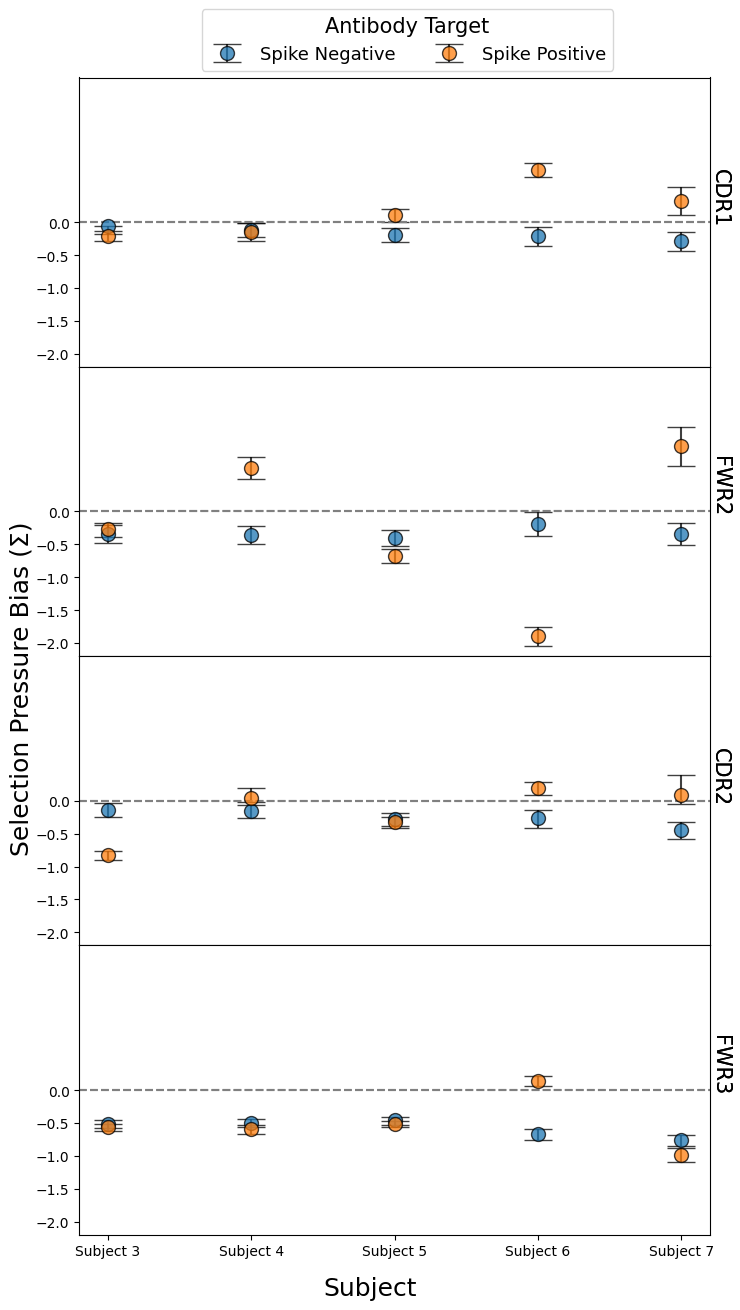

In [16]:
# Plotting figures based on the datasets:
plot_selection(dataset_path="output\\r_data\\motif_tpall_[2025-11-27_19-55-53]_baseline_values.csv",
               metadata_split="Antibody Target",
               save_fig=False)

if False:
    for dt in datasets_input:
        plot_selection(dataset_path=dt,
                       metadata_split="Antibody Target",
                       save_fig=False)

In [17]:
if False:   
    # Initiating the report object
    clones = nclones_report(dataset_name = "cl_seqs_motif.csv")

    # Creating a report that contains number of unique clones and sequence count per sub-dataset.
    clones_report = clones.groupby_count(groupby_list = ["subject_id", "ab_target"]) 
    #clones_sum = clones.get_sum_clones()

    print(clones_report)